In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy

from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'stixgeneral'
rcParams['mathtext.fontset'] = 'stix'

import pycbc
from pycbc import conversions, cosmology
from pycbc.distributions import Uniform, Gaussian
from pycbc.conversions import primary_mass, secondary_mass

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [13]:
labels = ['lambda1', 'lambda2', 'lambda_tilde', 'mass1', 'mass2', 'radius', 'mchirp', 'eos', 'radius_1p4']
samples_prior_rec2nsat_inj = {l: [] for l in labels}
distance = 20.7

dist_eos = Uniform(eos=(1, 2000.9))
dist_m = Uniform(mass1=(1.0, 2.0), mass2=(1.0, 2.0))
for (e,), (m1, m2) in zip(dist_eos.rvs(size=1000000), dist_m.rvs(size=1000000)):
    #if m1 < m2:
    #    continue
    m1p = primary_mass(m1, m2)
    m2s = secondary_mass(m1, m2)
    # apply mchirp
    mchirp = conversions.mchirp_from_mass1_mass2(m1p, m2s)
    if not 1.1876 < mchirp < 1.2076:
        continue

    e = int(e)

    MRLname = 'cs5MRL/'

    tov_file = '../../../LANL_Project_eos/' + MRLname + str(e) + '.dat'
    data = numpy.loadtxt(tov_file)
    radius_from_file = data[:, 0]
    mass_from_file = data[:, 1]
    lambda_from_file = data[:, 2]

    m1_src = m1p/(1.0 + pycbc.cosmology.redshift(distance))
    r1 = numpy.interp(m1_src, mass_from_file, radius_from_file)
    l1 = numpy.interp(m1_src, mass_from_file, lambda_from_file)

    m2_src = m2s/(1.0 + pycbc.cosmology.redshift(distance))
    l2 = numpy.interp(m2_src, mass_from_file, lambda_from_file)
    r2 = numpy.interp(m2_src, mass_from_file, radius_from_file)

    lt = conversions.lambda_tilde(m1_src, m2_src, l1, l2)

    r_1p4 = numpy.interp(1.4, mass_from_file, radius_from_file)

    samples_prior_rec2nsat_inj['mass1'].append(m1)
    samples_prior_rec2nsat_inj['mass2'].append(m2)
    #samples4['mchirp'].append(mchirp)
    #samples4['radius'].append(r)
    #samples4['lambda_s'].append(l)
    samples_prior_rec2nsat_inj['lambda1'].append(l1)
    samples_prior_rec2nsat_inj['lambda2'].append(l2)
    samples_prior_rec2nsat_inj['lambda_tilde'].append(lt)
    samples_prior_rec2nsat_inj['radius_1p4'].append(r_1p4)


samples_prior_uniform_inj = {l: [] for l in labels}

for (e,), (m1, m2) in zip(dist_eos.rvs(size=1000000), dist_m.rvs(size=1000000)):
    #if m1 < m2:
    #    continue
    m1p = primary_mass(m1, m2)
    m2s = secondary_mass(m1, m2)
    # apply mchirp
    mchirp = conversions.mchirp_from_mass1_mass2(m1p, m2s)
    if not 1.1876 < mchirp < 1.2076:
        continue

    e = int(e)

    MRLname = 'uniform/'

    tov_file = '../../../LANL_Project_eos/' + MRLname + str(e) + '.dat'
    data = numpy.loadtxt(tov_file)
    radius_from_file = data[:, 0]
    mass_from_file = data[:, 1]
    lambda_from_file = data[:, 2]

    m1_src = m1p/(1.0 + pycbc.cosmology.redshift(distance))
    r1 = numpy.interp(m1_src, mass_from_file, radius_from_file)
    l1 = numpy.interp(m1_src, mass_from_file, lambda_from_file)

    m2_src = m2s/(1.0 + pycbc.cosmology.redshift(distance))
    l2 = numpy.interp(m2_src, mass_from_file, lambda_from_file)
    r2 = numpy.interp(m2_src, mass_from_file, radius_from_file)

    lt = conversions.lambda_tilde(m1_src, m2_src, l1, l2)

    r_1p4 = numpy.interp(1.4, mass_from_file, radius_from_file)

    samples_prior_uniform_inj['mass1'].append(m1)
    samples_prior_uniform_inj['mass2'].append(m2)
    #samples4['mchirp'].append(mchirp)
    #samples4['radius'].append(r)
    #samples4['lambda_s'].append(l)
    samples_prior_uniform_inj['lambda1'].append(l1)
    samples_prior_uniform_inj['lambda2'].append(l2)
    samples_prior_uniform_inj['lambda_tilde'].append(lt)
    samples_prior_uniform_inj['radius_1p4'].append(r_1p4)

from pycbc.inference.io import loadfile
from pycbc.conversions import lambda_tilde

samples_post_rec2nsat_inj = {l: [] for l in labels}

fp=loadfile('../data/cs5_inj20_0130_ind.hdf','r+')

#parameters = fp['samples'].keys()
#samples = fp.read_samples(parameters, flatten=True)
m1=primary_mass(fp['samples']['mass1'][0:8000], fp['samples']['mass2'][0:8000])
m2=secondary_mass(fp['samples']['mass1'][0:8000], fp['samples']['mass2'][0:8000])
l1=fp['samples']['lambda1'][0:8000]
l2=fp['samples']['lambda2'][0:8000]
r1p4=fp['samples']['radius_1p4'][0:8000]

#m1=samples['mass1']
samples_post_rec2nsat_inj['mass1'] = m1
samples_post_rec2nsat_inj['mass2'] = m2
samples_post_rec2nsat_inj['lambda1'] = l1
samples_post_rec2nsat_inj['lambda2'] = l2
samples_post_rec2nsat_inj['lambda_tilde'] = lambda_tilde(m1,m2,l1,l2)
samples_post_rec2nsat_inj['radius_1p4'] = r1p4


samples_post_uniform_inj = {l: [] for l in labels}

fp=loadfile('../data/uniform_inj20_0130_ind.hdf','r+')

#parameters = fp['samples'].keys()
#samples = fp.read_samples(parameters, flatten=True)
m1=primary_mass(fp['samples']['mass1'][0:8000], fp['samples']['mass2'][0:8000])
m2=secondary_mass(fp['samples']['mass1'][0:8000], fp['samples']['mass2'][0:8000])
l1=fp['samples']['lambda1'][0:8000]
l2=fp['samples']['lambda2'][0:8000]
r1p4=fp['samples']['radius_1p4'][0:8000]

#m1=samples['mass1']
samples_post_uniform_inj['mass1'] = m1
samples_post_uniform_inj['mass2'] = m2
samples_post_uniform_inj['lambda1'] = l1
samples_post_uniform_inj['lambda2'] = l2
samples_post_uniform_inj['lambda_tilde'] = lambda_tilde(m1,m2,l1,l2)
samples_post_uniform_inj['radius_1p4'] = r1p4

In [14]:
import numpy as np
uniform_inj_median = np.mean(samples_post_uniform_inj['radius_1p4'])
cs5_inj_median = np.mean(samples_post_rec2nsat_inj['radius_1p4'])

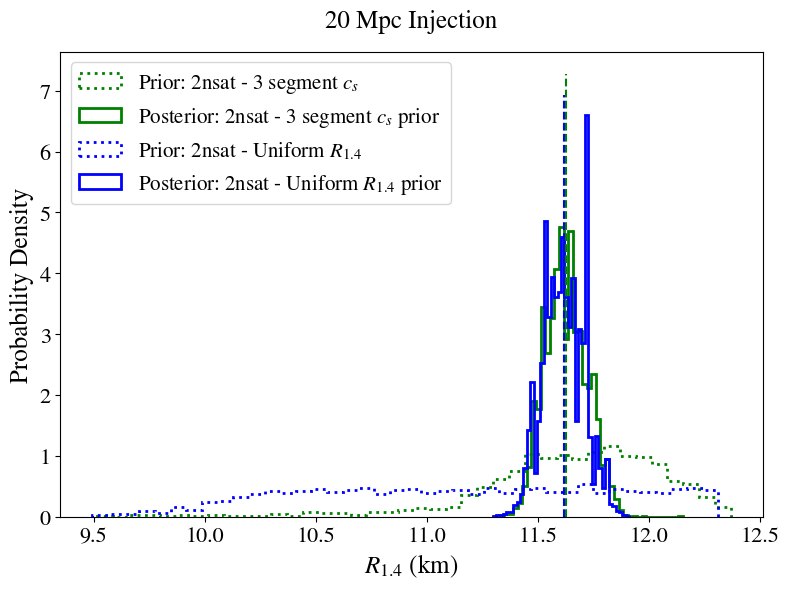

In [17]:
# plot r_1p4 priors and posterior
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
num_bins = 40

ax.hist(samples_prior_rec2nsat_inj['radius_1p4'], bins=40, histtype='step', facecolor='None', edgecolor='green', 
        ls='dotted', lw=2, density=True, label=r"Prior: 2nsat - 3 segment $c_s$")
ax.hist(samples_post_rec2nsat_inj['radius_1p4'], bins=num_bins, histtype='step',
        facecolor='None', edgecolor='green', ls='solid', lw=2,
        density=True, label=r"Posterior: 2nsat - 3 segment $c_s$ prior")

ax.hist(samples_prior_uniform_inj['radius_1p4'], bins=40, histtype='step', facecolor='None', edgecolor='blue',
        ls='dotted', lw=2, density=True, label=r"Prior: 2nsat - Uniform $R_{1.4}$")
ax.hist(samples_post_uniform_inj['radius_1p4'], bins=num_bins, histtype='step',
        facecolor='None', edgecolor='blue', ls='solid', lw=2,
        density=True, label=r"Posterior: 2nsat - Uniform $R_{1.4}$ prior")

ax.vlines(uniform_inj_median, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], ls='--', color='blue')
ax.vlines(cs5_inj_median, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], ls='--', color='green')

plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel(r"$R_{1.4}$ (km)", fontsize=18)
plt.ylabel(r"Probability Density", fontsize=18)
plt.legend(fontsize=15)
plt.title('20 Mpc Injection', fontsize=18, pad=18)
plt.tight_layout()
plt.savefig("../plots/r1p4_prior_post_inj20.png")

In [15]:
labels = ['lambda1', 'lambda2', 'lambda_tilde', 'mass1', 'mass2', 'radius', 'mchirp', 'eos', 'radius_1p4']
samples_prior_rec2nsat = {l: [] for l in labels}
distance = 40.7

dist_eos = Uniform(eos=(1, 2000.9))
dist_m = Uniform(mass1=(1.0, 2.0), mass2=(1.0, 2.0))
for (e,), (m1, m2) in zip(dist_eos.rvs(size=1000000), dist_m.rvs(size=1000000)):
    #if m1 < m2:
    #    continue
    m1p = primary_mass(m1, m2)
    m2s = secondary_mass(m1, m2)
    # apply mchirp
    mchirp = conversions.mchirp_from_mass1_mass2(m1p, m2s)
    if not 1.1876 < mchirp < 1.2076:
        continue

    e = int(e)

    MRLname = 'cs5MRL/'

    tov_file = '../../../LANL_Project_eos/' + MRLname + str(e) + '.dat'
    data = numpy.loadtxt(tov_file)
    radius_from_file = data[:, 0]
    mass_from_file = data[:, 1]
    lambda_from_file = data[:, 2]

    m1_src = m1p/(1.0 + pycbc.cosmology.redshift(distance))
    r1 = numpy.interp(m1_src, mass_from_file, radius_from_file)
    l1 = numpy.interp(m1_src, mass_from_file, lambda_from_file)

    m2_src = m2s/(1.0 + pycbc.cosmology.redshift(distance))
    l2 = numpy.interp(m2_src, mass_from_file, lambda_from_file)
    r2 = numpy.interp(m2_src, mass_from_file, radius_from_file)

    lt = conversions.lambda_tilde(m1_src, m2_src, l1, l2)

    r_1p4 = numpy.interp(1.4, mass_from_file, radius_from_file)

    samples_prior_rec2nsat['mass1'].append(m1)
    samples_prior_rec2nsat['mass2'].append(m2)
    #samples4['mchirp'].append(mchirp)
    #samples4['radius'].append(r)
    #samples4['lambda_s'].append(l)
    samples_prior_rec2nsat['lambda1'].append(l1)
    samples_prior_rec2nsat['lambda2'].append(l2)
    samples_prior_rec2nsat['lambda_tilde'].append(lt)
    samples_prior_rec2nsat['radius_1p4'].append(r_1p4)


samples_prior_uniform = {l: [] for l in labels}

for (e,), (m1, m2) in zip(dist_eos.rvs(size=1000000), dist_m.rvs(size=1000000)):
    #if m1 < m2:
    #    continue
    m1p = primary_mass(m1, m2)
    m2s = secondary_mass(m1, m2)
    # apply mchirp
    mchirp = conversions.mchirp_from_mass1_mass2(m1p, m2s)
    if not 1.1876 < mchirp < 1.2076:
        continue

    e = int(e)

    MRLname = 'uniform/'

    tov_file = '../../../LANL_Project_eos/' + MRLname + str(e) + '.dat'
    data = numpy.loadtxt(tov_file)
    radius_from_file = data[:, 0]
    mass_from_file = data[:, 1]
    lambda_from_file = data[:, 2]

    m1_src = m1p/(1.0 + pycbc.cosmology.redshift(distance))
    r1 = numpy.interp(m1_src, mass_from_file, radius_from_file)
    l1 = numpy.interp(m1_src, mass_from_file, lambda_from_file)

    m2_src = m2s/(1.0 + pycbc.cosmology.redshift(distance))
    l2 = numpy.interp(m2_src, mass_from_file, lambda_from_file)
    r2 = numpy.interp(m2_src, mass_from_file, radius_from_file)

    lt = conversions.lambda_tilde(m1_src, m2_src, l1, l2)

    r_1p4 = numpy.interp(1.4, mass_from_file, radius_from_file)

    samples_prior_uniform['mass1'].append(m1)
    samples_prior_uniform['mass2'].append(m2)
    #samples4['mchirp'].append(mchirp)
    #samples4['radius'].append(r)
    #samples4['lambda_s'].append(l)
    samples_prior_uniform['lambda1'].append(l1)
    samples_prior_uniform['lambda2'].append(l2)
    samples_prior_uniform['lambda_tilde'].append(lt)
    samples_prior_uniform['radius_1p4'].append(r_1p4)

from pycbc.inference.io import loadfile
from pycbc.conversions import lambda_tilde

samples_post_rec2nsat = {l: [] for l in labels}

fp=loadfile('../data/cs5_0829_ind.hdf','r+')

#parameters = fp['samples'].keys()
#samples = fp.read_samples(parameters, flatten=True)
m1=primary_mass(fp['samples']['mass1'][0:8000], fp['samples']['mass2'][0:8000])
m2=secondary_mass(fp['samples']['mass1'][0:8000], fp['samples']['mass2'][0:8000])
l1=fp['samples']['lambda1'][0:8000]
l2=fp['samples']['lambda2'][0:8000]
r1p4=fp['samples']['radius_1p4'][0:8000]

#m1=samples['mass1']
samples_post_rec2nsat['mass1'] = m1
samples_post_rec2nsat['mass2'] = m2
samples_post_rec2nsat['lambda1'] = l1
samples_post_rec2nsat['lambda2'] = l2
samples_post_rec2nsat['lambda_tilde'] = lambda_tilde(m1,m2,l1,l2)
samples_post_rec2nsat['radius_1p4'] = r1p4


samples_post_uniform = {l: [] for l in labels}

fp=loadfile('../data/uniform_1010_ind.hdf','r+')

#parameters = fp['samples'].keys()
#samples = fp.read_samples(parameters, flatten=True)
m1=primary_mass(fp['samples']['mass1'][0:8000], fp['samples']['mass2'][0:8000])
m2=secondary_mass(fp['samples']['mass1'][0:8000], fp['samples']['mass2'][0:8000])
l1=fp['samples']['lambda1'][0:8000]
l2=fp['samples']['lambda2'][0:8000]
r1p4=fp['samples']['radius_1p4'][0:8000]

#m1=samples['mass1']
samples_post_uniform['mass1'] = m1
samples_post_uniform['mass2'] = m2
samples_post_uniform['lambda1'] = l1
samples_post_uniform['lambda2'] = l2
samples_post_uniform['lambda_tilde'] = lambda_tilde(m1,m2,l1,l2)
samples_post_uniform['radius_1p4'] = r1p4

#get medians for plots
uniform_median = np.mean(samples_post_uniform['radius_1p4'])
cs5_median = np.mean(samples_post_rec2nsat['radius_1p4'])

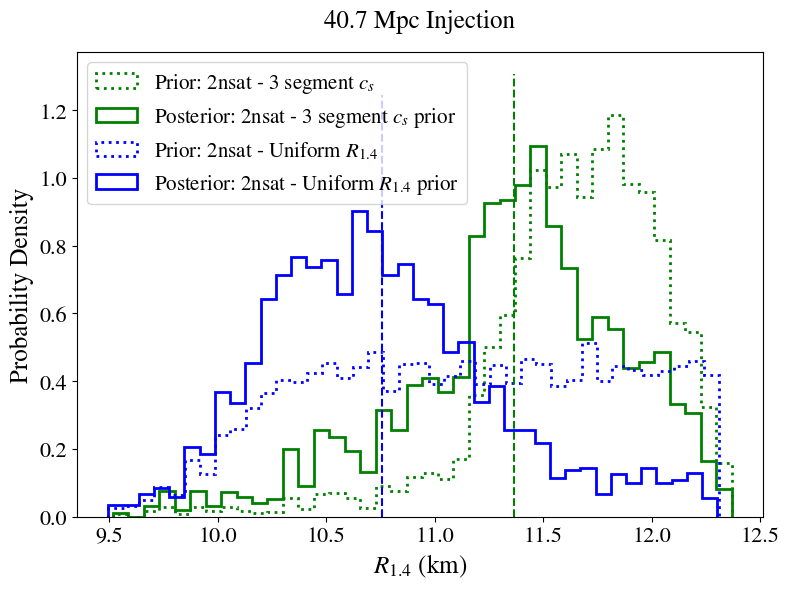

In [19]:
# plot r_1p4 priors and posterior
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
num_bins = 40

ax.hist(samples_prior_rec2nsat['radius_1p4'], bins=40, histtype='step', facecolor='None', edgecolor='green', 
        ls='dotted', lw=2, density=True, label=r"Prior: 2nsat - 3 segment $c_s$")
ax.hist(samples_post_rec2nsat['radius_1p4'], bins=num_bins, histtype='step',
        facecolor='None', edgecolor='green', ls='solid', lw=2,
        density=True, label=r"Posterior: 2nsat - 3 segment $c_s$ prior")

ax.hist(samples_prior_uniform['radius_1p4'], bins=40, histtype='step', facecolor='None', edgecolor='blue',
        ls='dotted', lw=2, density=True, label=r"Prior: 2nsat - Uniform $R_{1.4}$")
ax.hist(samples_post_uniform['radius_1p4'], bins=num_bins, histtype='step',
        facecolor='None', edgecolor='blue', ls='solid', lw=2,
        density=True, label=r"Posterior: 2nsat - Uniform $R_{1.4}$ prior")

ax.vlines(uniform_median, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], ls='--', color='blue')
ax.vlines(cs5_median, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], ls='--', color='green')

plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel(r"$R_{1.4}$ (km)", fontsize=18)
plt.ylabel(r"Probability Density", fontsize=18)
plt.legend(fontsize=15)
plt.title('40.7 Mpc Injection', fontsize=18, pad=18)
plt.tight_layout()
plt.savefig("../plots/r1p4_prior_post.png")

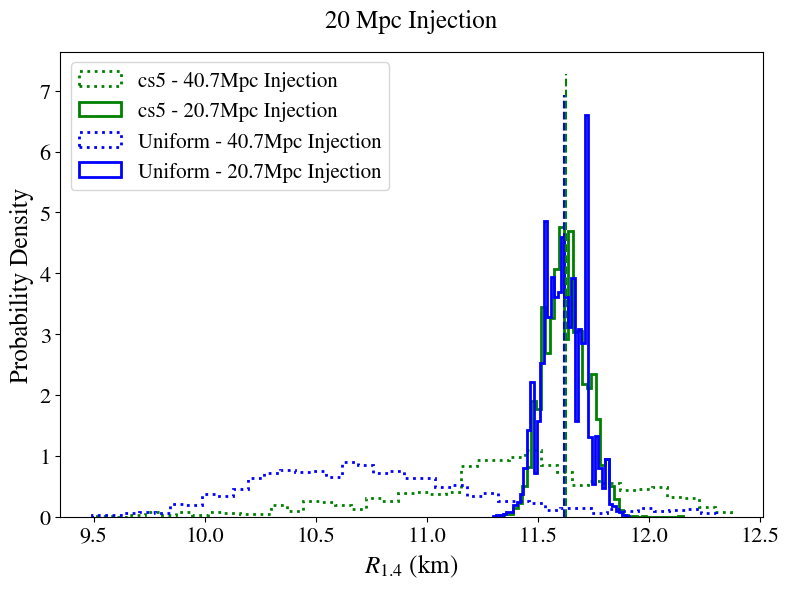

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
num_bins = 40

ax.hist(samples_post_rec2nsat['radius_1p4'], bins=40, histtype='step', facecolor='None', edgecolor='green', 
        ls='dotted', lw=2, density=True, label=r"cs5 - 40.7Mpc Injection")
ax.hist(samples_post_rec2nsat_inj['radius_1p4'], bins=num_bins, histtype='step',
        facecolor='None', edgecolor='green', ls='solid', lw=2,
        density=True, label=r"cs5 - 20.7Mpc Injection")

ax.hist(samples_post_uniform['radius_1p4'], bins=40, histtype='step', facecolor='None', edgecolor='blue',
        ls='dotted', lw=2, density=True, label=r"Uniform - 40.7Mpc Injection")
ax.hist(samples_post_uniform_inj['radius_1p4'], bins=num_bins, histtype='step',
        facecolor='None', edgecolor='blue', ls='solid', lw=2,
        density=True, label=r"Uniform - 20.7Mpc Injection")

ax.vlines(uniform_inj_median, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], ls='--', color='blue')
ax.vlines(cs5_inj_median, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], ls='--', color='green')

plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel(r"$R_{1.4}$ (km)", fontsize=18)
plt.ylabel(r"Probability Density", fontsize=18)
plt.legend(fontsize=15)
plt.title('20 Mpc Injection', fontsize=18, pad=18)
plt.tight_layout()
plt.savefig("../plots/r1p4_inj_comparison.png")